# Sunspot number prediction

This is an example of time series modeling. The data used is the SILSO sunspot number, from the Royal Observatory of Belgium, Brussels (<http://sidc.be/silso/home>).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import geoml

The data comes as the total daily count, monthly and yearly averages. Refer to the website for detailed information about the data.

In [2]:
yearly, monthly, daily = geoml.data.Examples.sunspot_number()

In [3]:
yearly

Object of class Points1D with 319 data locations

Data preview:

     year    sn  sn_std  n_obs  definitive
0  1700.5   8.3    -1.0     -1           1
1  1701.5  18.3    -1.0     -1           1
2  1702.5  26.7    -1.0     -1           1
3  1703.5  38.3    -1.0     -1           1
4  1704.5  60.0    -1.0     -1           1

## Model training

We will use the spectral mixture kernel (Wilson and Adams, 2013). It can be reproduced here by specifiying a product between a cosine kernel and a Gaussian. We add 5 such kernels to catch low- and high-frequency patterns.

The sunspot number must be positive, so we use a softplus warping to ensure positivity and a spline warping to handle an anisotropic data distribution.

In [4]:
# A nested list specifies the product.
kernels = [[geoml.kernels.GaussianKernel(geoml.transform.Isotropic(10)),
           geoml.kernels.CosineKernel(geoml.transform.Isotropic(20))] for _ in range(5)]

# Warpings are applied to the data in order.
warping = [geoml.warping.Softplus(), 
           geoml.warping.Spline(n_knots=5)]

gp = geoml.models.GP(yearly, variable="sn", kernels=kernels, warping=warping)
gp.train(seed=1234, max_iter=20000, mut_prob=0.5)

Instructions for updating:
Colocations handled automatically by placer.
Initializing population..................................................

Iteration: 8690 | Best fitness: -1425.2443233318472 | Improvement <0.1 for 3999/4000.0 iterations        
Terminating training at iteration 8691


The trained model. The parameter "range" in the `CosineKernel` object actually represents the wave's period. The `ExponentialKernel`'s range determines how far in time the pattern persists, while the variance represents the pattern's contribution to the overall variance of the data.

It can be seen that there is a strong contribution from a pattern with period between 10-11 years, and a smaller one with period of 108 years.

In [5]:
print(gp)

A GP object

Covariance model: A CovarianceModelRegression object

Base transform: Identity

Variance is free

Nugget: 0.016505946484509808

Position 0: variance = 0.0002723676196894319

	Position [0][0]: GaussianKernel - Isotropic
		range: [2311.8998638] (free)

	Position [0][1]: CosineKernel - Isotropic
		range: [3.95121758] (free)

Position 1: variance = 0.12460491602279007

	Position [1][0]: GaussianKernel - Isotropic
		range: [571.38091588] (free)

	Position [1][1]: CosineKernel - Isotropic
		range: [122.61178601] (free)

Position 2: variance = 0.3933700733933829

	Position [2][0]: GaussianKernel - Isotropic
		range: [87.8721374] (free)

	Position [2][1]: CosineKernel - Isotropic
		range: [10.65548297] (free)

Position 3: variance = 0.4624944443828417

	Position [3][0]: GaussianKernel - Isotropic
		range: [5.32898444] (free)

	Position [3][1]: CosineKernel - Isotropic
		range: [55.40071871] (free)

Position 4: variance = 0.0027522520967862047

	Position [4][0]: GaussianKernel - Is

## Prediction

Let us make a prediction up to year 2050.

In [6]:
grid = geoml.data.Grid1D(start=2018, n=33, step=1)

gp.predict(grid, verbose=False)
print(grid)

Object of class Grid1D with 33 data locations

Data preview:

    sn_mean  sn_variance     ...        sn_p0.75   sn_p0.975
0 -0.957191     0.030312     ...       13.661745   24.205740
1 -0.940417     0.100910     ...       18.880401   40.168102
2 -0.726132     0.289317     ...       37.564126   86.387536
3 -0.364726     0.496024     ...       68.513712  159.063529
4  0.014761     0.609549     ...      106.718330  216.464430

[5 rows x 7 columns]


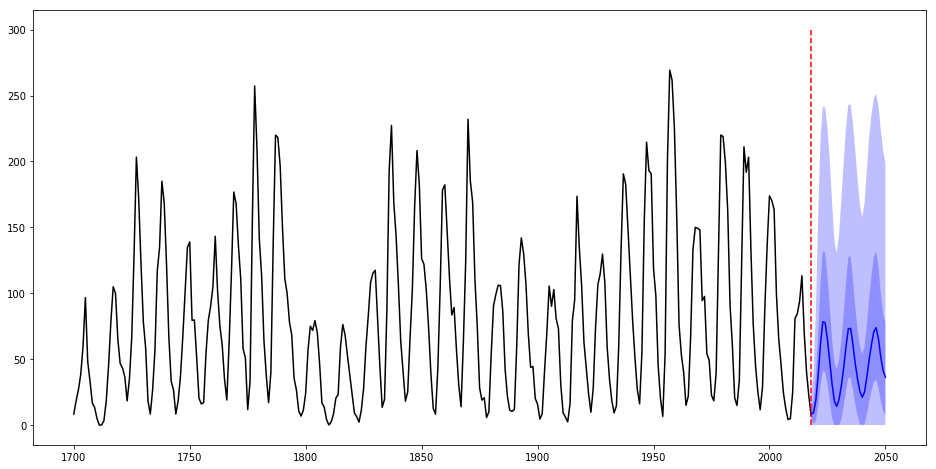

In [7]:
plt.figure(figsize=(16,8))
plt.plot(yearly.coords, yearly.data["sn"].values, "k-")
plt.fill_between(np.squeeze(grid.coords), grid.data["sn_p0.975"].values, grid.data["sn_p0.025"].values,
                 facecolor="blue", alpha=0.25)
plt.fill_between(np.squeeze(grid.coords), grid.data["sn_p0.75"].values, grid.data["sn_p0.25"].values,
                 facecolor="blue", alpha=0.25)
plt.plot(np.array([2018, 2018]), np.array([0, 300]), "r--")
plt.plot(grid.coords, grid.data["sn_p0.5"].values, "b-")
plt.show()

A closer look at the prediction:

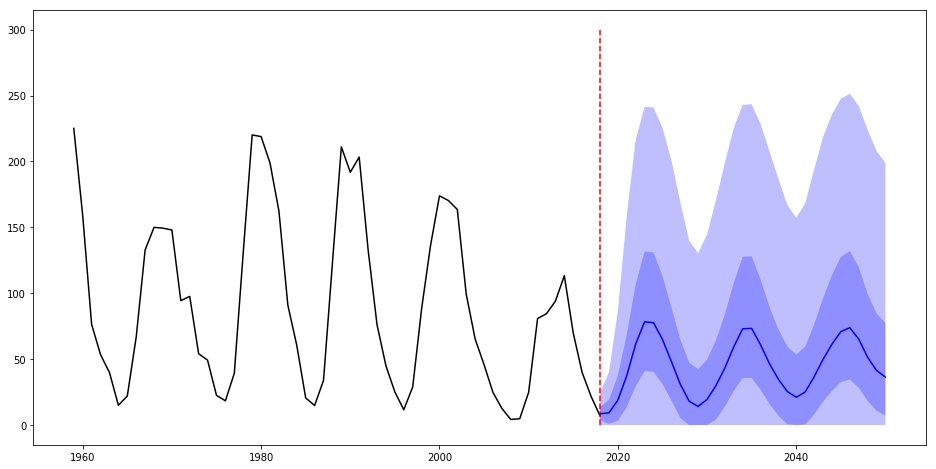

In [8]:
plt.figure(figsize=(16,8))
plt.plot(yearly.coords[-60:], yearly.data["sn"].values[-60:], "k-")
plt.fill_between(np.squeeze(grid.coords), grid.data["sn_p0.975"].values, grid.data["sn_p0.025"].values,
                 facecolor="blue", alpha=0.25)
plt.fill_between(np.squeeze(grid.coords), grid.data["sn_p0.75"].values, grid.data["sn_p0.25"].values,
                 facecolor="blue", alpha=0.25)
plt.plot(np.array([2018, 2018]), np.array([0, 300]), "r--")
plt.plot(grid.coords, grid.data["sn_p0.5"].values, "b-")
plt.show()

The blue line is the median of the predictive distribution, while the ribbons mark the 95% confidence interval and interquartile range. The dashed line marks the limit of the training data. See how the warping prevents negative predictions, and makes the predictive distribution asymmetric.

## References

Rasmussen, C. E., & Williams, C. K. I. (2006). Gaussian processes for machine learning. Cambridge, Massachusetts: MIT Press. https://doi.org/10.1142/S0129065704001899

Snelson, E., Rasmussen, C. E., & Ghahramani, Z. (2004). Warped Gaussian processes. Adv Neural Inf Process Syst 16, 16, 337–344.

Wilson, A. G., & Adams, R. P. (2013). Gaussian Process Kernels for Pattern Discovery and Extrapolation. In 30th International Conference on Machine Learning (Vol. 28, pp. 1067–1075). Atlanta. Retrieved from http://arxiv.org/abs/1302.4245